In [1]:
%matplotlib inline
import numpy as np
import yt
from galaxy_analysis import Galaxy
import matplotlib.pyplot as plt
from galaxy_analysis.plot.plot_styles import *

In [2]:
wdir = "/media/aemerick/Seagate Expansion Drive/FlatironData/run11_30km/sn_H2atten_H2sh/"

ds = yt.load(wdir + 'DD0239/DD0239')
data = ds.all_data()

#gal = Galaxy('DD0369',wdir=wdir)

In [3]:
#gal.ds.derived_field_list

In [4]:
data['thermal_energy']

Parsing Hierarchy : 100%|██████████| 2382/2382 [00:00<00:00, 10875.71it/s]


YTArray([1.37330443e+12, 1.38117453e+12, 1.37932464e+12, ...,
         3.22705553e+11, 4.44269137e+11, 3.66920773e+11]) erg/g

In [5]:
#
# Define region
#
dL = 400 * yt.units.pc
region = None
above_region = data.cut_region(["(obj['cylindrical_z'].in_units('kpc') > 0.8) & (obj['cylindrical_z'].in_units('kpc') < 1.2) & (obj['cylindrical_radius'].in_units('kpc') < 2)"])
above_hot_region = above_region.cut_region(["obj['temperature'].in_units('K') > 3.0E5"])
above_cold_region = above_region.cut_region(["obj['temperature'].in_units('K') < 3.0E5"])

below_region = data.cut_region(["(obj['cylindrical_z'].in_units('kpc') < -0.8) & np.abs(obj['cylindrical_z'].in_units('kpc') > -1.2) & (obj['cylindrical_radius'].in_units('kpc') < 2)"])
below_hot_region = below_region.cut_region(["obj['temperature'].in_units('K') > 3.0E5"])
below_cold_region = below_region.cut_region(["obj['temperature'].in_units('K') < 3.0E5"])

In [6]:
#
# Define region
#

def compute_energy_loading(ds, data):
    
    birth_mass = data['birth_mass']
    birth_time = data['creation_time'].to('Myr')
    pt = data['particle_type']

    t = ds.current_time.to('Myr')


    select = ((birth_mass > 8.0) * (birth_mass < 25.0)) * (pt > 11) * ((t - birth_time ) < 40*yt.units.Myr)

    N_SN = np.size(birth_mass[select])

    dL = 200 * yt.units.pc
    region = None
    above_region = data.cut_region(["(obj['cylindrical_z'].in_units('kpc') > 0.9) & (obj['cylindrical_z'].in_units('kpc') < 1.1) & (obj['cylindrical_radius'].in_units('kpc') < 2)"])
    above_hot_region = above_region.cut_region(["obj['temperature'].in_units('K') > 3.0E5"])
    above_cold_region = above_region.cut_region(["obj['temperature'].in_units('K') < 3.0E5"])
    above_colder_region = above_region.cut_region(["obj['temperature'].in_units('K') < 1.0E4"])

    below_region = data.cut_region(["(obj['cylindrical_z'].in_units('kpc') < -0.9) & np.abs(obj['cylindrical_z'].in_units('kpc') > -1.1) & (obj['cylindrical_radius'].in_units('kpc') < 2)"])
    below_hot_region = below_region.cut_region(["obj['temperature'].in_units('K') > 3.0E5"])
    below_cold_region = below_region.cut_region(["obj['temperature'].in_units('K') < 3.0E5"])
    below_colder_region = below_region.cut_region(["obj['temperature'].in_units('K') < 1.0E4"])


    vals = np.zeros(4)
    
    if N_SN == 0:
        print("No Supernova this time step")
        return vals
    
    
    i = 0
    for above_reg, below_reg in [(above_region, below_region),
                                 (above_hot_region,below_hot_region),
                                 (above_cold_region,below_cold_region),
                                 (above_colder_region,below_colder_region)]:
    
        M  = above_reg['cell_mass'].to('Msun')
        v  = above_reg['z-velocity'].to('km/s')
        cV = above_reg['cell_volume'].to('cm**(3)')
        KE = 0.5*M*above_reg['velocity_magnitude']**2
        
        select = v > 0                  
        above_E_out_therm = (v / dL * above_reg['thermal_energy'].to('erg/g') * M).to('erg/s')[select]
        above_E_out_kin   = (v / dL * KE).to('erg/s')[select]
    
        M  = below_reg['cell_mass'].to('Msun')
        v  = below_reg['z-velocity'].to('km/s')
        cV = below_reg['cell_volume'].to('cm**(3)')
        KE = 0.5*M*below_reg['velocity_magnitude']**2
        
        select = v < 0           
        below_E_out_therm = (-v / dL * below_reg['thermal_energy'].to('erg/g') * M).to('erg/s')[select]
        below_E_out_kin   = (-v / dL * KE).to('erg/s')[select]    
    
    
        E_out_therm = np.sum(above_E_out_therm) + np.sum(below_E_out_therm)
        E_out_kin   = np.sum(above_E_out_kin  ) + np.sum(below_E_out_kin  )
        E_out_tot   = E_out_therm + E_out_kin
    
        #print("Out-rate      :  %10.3E %10.3E %10.3E"%(E_out_therm.value, E_out_kin.value, E_out_tot.value))
        x = N_SN*yt.units.erg*1.0E51 / ((40.0*yt.units.Myr).to('s'))
        #print("Loading Factor: %10.3E %10.3E %10.3E"%((E_out_therm/x).value, (E_out_kin/x).value, (E_out_tot/x).value))
    

        vals[i] = (E_out_tot/x).value
        i = i + 1
    
    return vals

In [11]:
import glob
dsnames = np.sort(np.array(glob.glob(wdir + "DD??00/DD??00") + glob.glob(wdir+"DD??50/DD??50") +
                           glob.glob(wdir + "DD??25/DD??25") + glob.glob(wdir+"DD??75/DD??75")))

print(dsnames)

['/media/aemerick/Seagate Expansion Drive/FlatironData/run11_30km/sn_H2atten_H2sh/DD0000/DD0000'
 '/media/aemerick/Seagate Expansion Drive/FlatironData/run11_30km/sn_H2atten_H2sh/DD0025/DD0025'
 '/media/aemerick/Seagate Expansion Drive/FlatironData/run11_30km/sn_H2atten_H2sh/DD0050/DD0050'
 '/media/aemerick/Seagate Expansion Drive/FlatironData/run11_30km/sn_H2atten_H2sh/DD0075/DD0075'
 '/media/aemerick/Seagate Expansion Drive/FlatironData/run11_30km/sn_H2atten_H2sh/DD0100/DD0100'
 '/media/aemerick/Seagate Expansion Drive/FlatironData/run11_30km/sn_H2atten_H2sh/DD0125/DD0125'
 '/media/aemerick/Seagate Expansion Drive/FlatironData/run11_30km/sn_H2atten_H2sh/DD0150/DD0150'
 '/media/aemerick/Seagate Expansion Drive/FlatironData/run11_30km/sn_H2atten_H2sh/DD0175/DD0175'
 '/media/aemerick/Seagate Expansion Drive/FlatironData/run11_30km/sn_H2atten_H2sh/DD0200/DD0200'
 '/media/aemerick/Seagate Expansion Drive/FlatironData/run11_30km/sn_H2atten_H2sh/DD0225/DD0225'
 '/media/aemerick/Seagate Expa

In [13]:

j = 0
ds_select = dsnames[5:]
hot_loading = np.zeros(np.size(ds_select))
cold_loading = np.zeros(np.size(ds_select))
colder_loading = np.zeros(np.size(ds_select))

loading = np.zeros(np.size(ds_select))

times = np.zeros(np.size(ds_select))
for dsname in ds_select:
    ds = yt.load(dsname)
    data = ds.all_data()
    
    times[j] = ds.current_time.to('Myr')
    
    x,y,z,w = compute_energy_loading(ds,data)
    
    loading[j]      = x
    hot_loading[j]  = y
    cold_loading[j] = z
    colder_loading[j] = w
    
    
    
    print("%5.2f Myr:   %10.3E  %10.3E  %10.3E  %10.3E"%(times[j],loading[j],hot_loading[j],cold_loading[j],colder_loading[j]))
    j = j + 1
    

Parsing Hierarchy : 100%|██████████| 1418/1418 [00:00<00:00, 14769.67it/s]


No Supernova this time step
125.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 1587/1587 [00:00<00:00, 14242.13it/s]


150.00 Myr:    3.722E-03   0.000E+00   3.722E-03   1.559E-03


Parsing Hierarchy : 100%|██████████| 2866/2866 [00:00<00:00, 14233.22it/s]


175.00 Myr:    6.997E-01   5.386E-01   1.612E-01   6.647E-03


Parsing Hierarchy : 100%|██████████| 2955/2955 [00:00<00:00, 8521.17it/s] 


200.00 Myr:    5.145E-01   1.855E-01   3.290E-01   1.205E-02


Parsing Hierarchy : 100%|██████████| 2696/2696 [00:00<00:00, 7027.79it/s]


225.00 Myr:    5.850E-01   1.610E-01   4.239E-01   2.670E-03


Parsing Hierarchy : 100%|██████████| 1820/1820 [00:00<00:00, 5875.94it/s] 


250.00 Myr:    8.809E-01   6.342E-01   2.467E-01   2.706E-03


Parsing Hierarchy : 100%|██████████| 708/708 [00:00<00:00, 10638.27it/s]


275.00 Myr:    5.860E-01   0.000E+00   5.860E-01   3.251E-01


Parsing Hierarchy : 100%|██████████| 2276/2276 [00:00<00:00, 6330.05it/s]


300.00 Myr:    5.690E-01   0.000E+00   5.690E-01   2.515E-01


Parsing Hierarchy : 100%|██████████| 1977/1977 [00:00<00:00, 5625.41it/s]


325.00 Myr:    2.102E-01   4.182E-02   1.683E-01   3.324E-03


Parsing Hierarchy : 100%|██████████| 550/550 [00:00<00:00, 2870.32it/s]


350.00 Myr:    2.412E-01   5.887E-03   2.353E-01   4.945E-02


Parsing Hierarchy : 100%|██████████| 1698/1698 [00:00<00:00, 11800.16it/s]


375.00 Myr:    1.826E-01   0.000E+00   1.826E-01   3.692E-02


Parsing Hierarchy : 100%|██████████| 2232/2232 [00:00<00:00, 14692.40it/s]


400.00 Myr:    3.556E-01   5.767E-02   2.980E-01   3.602E-03


Parsing Hierarchy : 100%|██████████| 2012/2012 [00:00<00:00, 13767.09it/s]


425.00 Myr:    4.307E-01   1.540E-01   2.767E-01   1.755E-04


Parsing Hierarchy : 100%|██████████| 1633/1633 [00:00<00:00, 15071.72it/s]


450.00 Myr:    3.217E-01   5.124E-02   2.705E-01   1.304E-02


Parsing Hierarchy : 100%|██████████| 1662/1662 [00:00<00:00, 11012.95it/s]


475.00 Myr:    1.356E+00   2.624E-01   1.094E+00   3.527E-02


Parsing Hierarchy : 100%|██████████| 566/566 [00:00<00:00, 2621.86it/s]


No Supernova this time step
500.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 1484/1484 [00:00<00:00, 11392.39it/s]


525.00 Myr:    6.844E-02   0.000E+00   6.844E-02   2.023E-02


Parsing Hierarchy : 100%|██████████| 1891/1891 [00:00<00:00, 13819.00it/s]


550.00 Myr:    4.035E+00   2.369E+00   1.666E+00   1.759E-02


Parsing Hierarchy : 100%|██████████| 1947/1947 [00:00<00:00, 6204.88it/s]


575.00 Myr:    5.482E-01   1.726E-01   3.756E-01   3.590E-05


Parsing Hierarchy : 100%|██████████| 1464/1464 [00:00<00:00, 5287.16it/s]


600.00 Myr:    1.212E+00   6.081E-01   6.040E-01   8.372E-03


Parsing Hierarchy : 100%|██████████| 468/468 [00:00<00:00, 8820.91it/s]


625.00 Myr:    2.126E-01   1.081E-01   1.045E-01   8.406E-03


Parsing Hierarchy : 100%|██████████| 429/429 [00:00<00:00, 14563.67it/s]


No Supernova this time step
650.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 382/382 [00:00<00:00, 7313.69it/s]


No Supernova this time step
675.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 417/417 [00:00<00:00, 2189.62it/s]


No Supernova this time step
700.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 1231/1231 [00:00<00:00, 12656.95it/s]


725.00 Myr:    2.622E-02   0.000E+00   2.622E-02   3.654E-03


Parsing Hierarchy : 100%|██████████| 1143/1143 [00:00<00:00, 14573.43it/s]


750.00 Myr:    3.469E-01   1.885E-01   1.584E-01   4.239E-05


Parsing Hierarchy : 100%|██████████| 1509/1509 [00:00<00:00, 6205.21it/s]


775.00 Myr:    1.797E+00   9.068E-01   8.899E-01   6.595E-03


Parsing Hierarchy : 100%|██████████| 372/372 [00:00<00:00, 13118.22it/s]


800.00 Myr:    8.360E-01   3.559E-01   4.802E-01   1.702E-03


Parsing Hierarchy : 100%|██████████| 1219/1219 [00:00<00:00, 10732.07it/s]


No Supernova this time step
825.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 1225/1225 [00:00<00:00, 5538.33it/s]


850.00 Myr:    1.112E+00   6.582E-01   4.533E-01   1.021E-02


Parsing Hierarchy : 100%|██████████| 1238/1238 [00:00<00:00, 5255.98it/s] 


875.00 Myr:    7.948E-01   2.447E-01   5.501E-01   7.168E-04


Parsing Hierarchy : 100%|██████████| 320/320 [00:00<00:00, 11956.18it/s]


No Supernova this time step
900.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 1125/1125 [00:00<00:00, 3111.51it/s]


No Supernova this time step
925.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 247/247 [00:00<00:00, 14619.66it/s]


No Supernova this time step
950.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 281/281 [00:00<00:00, 9273.59it/s]


No Supernova this time step
975.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 1093/1093 [00:00<00:00, 14773.53it/s]


No Supernova this time step
1000.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


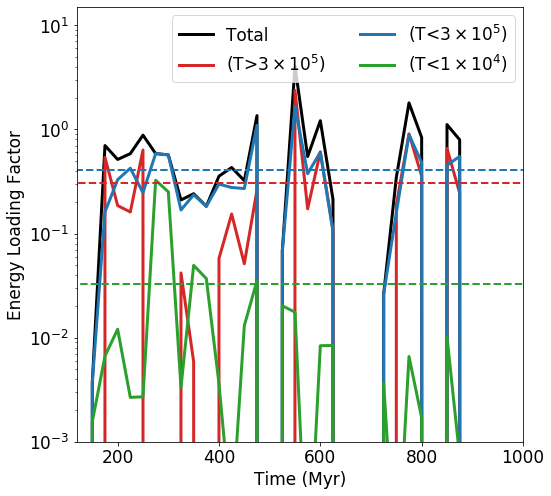

In [25]:

rc('font',size=17)

fig,ax=plt.subplots()
fig.set_size_inches(8,8)

ax.plot(times,loading,lw = 3,color='black',label='Total')
ax.plot(times,hot_loading,lw=3,color='C3',label=r'(T>$3 \times 10^5$)')
ax.plot(times,cold_loading,lw=3,color='C0',label=r'(T<$3 \times 10^5$)')
ax.plot(times,colder_loading,lw=3,color='C2',label=r'(T<$1 \times 10^4$)')


select = loading>0
ax.plot(ax.get_xlim(), [np.average(hot_loading[select])]*2, lw = 2, ls = '--', color = 'C3')
ax.plot(ax.get_xlim(), [np.average(cold_loading[select])]*2, lw = 2, ls = '--', color = 'C0')
ax.plot(ax.get_xlim(), [np.average(colder_loading[select])]*2, lw = 2, ls = '--', color = 'C2')

ax.legend(loc='best',ncol=2)

ax.set_ylim(1.0E-3,15.0)
ax.set_xlim(119.0,1000.0)
ax.semilogy()

ax.set_ylabel('Energy Loading Factor')
ax.set_xlabel('Time (Myr)')
fig.savefig('energy_loading.png')

In [17]:
print(np.average(hot_loading),np.average(cold_loading),np.average(colder_loading))

0.2140025542158142 0.2839159824908608 0.022821366943430607
